Run all cells and download relevant libraries

In [4]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import albumentations as A
import warnings
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm.notebook import tqdm
from transformers import AutoModel
from albumentations.pytorch import ToTensorV2

# Import your helper script
import preprocess 

# --- 0. CONFIGURATION ---
warnings.filterwarnings("ignore")
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

class CFG:
    root_dir = Path("./data_patches") 
    patch_size = 518             
    batch_size = 16               
    lr = 1e-4                     
    epochs = 20                   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_workers = 0              
    pin_memory = True            
    model_name = "DINOv2_Final_Stable"
    target_limit = 20000
    meta_cache = Path("train_metadata.json")

In [5]:
class LeanDataset(Dataset):
    def __init__(self, patch_meta, split_type='train', transform=None):
        self.patch_meta = patch_meta 
        self.split_type = split_type 
        self.transform = transform
        
    def __len__(self): return len(self.patch_meta)
    
    def __getitem__(self, idx):
        img_path, x, y, size, is_forged = self.patch_meta[idx]
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None: return torch.zeros((3, size, size)), torch.zeros((1, size, size))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = None
            if is_forged:
                m_path = Path(img_path).parents[1] / "masks" / (Path(img_path).stem + ".npy")
                if m_path.exists():
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
            
            if self.split_type == 'val':
                patch, mask = preprocess.process_val_image(img, mask, size)
            else:
                h, w, _ = img.shape
                y_end, x_end = min(y + size, h), min(x + size, w)
                patch = img[y:y_end, x:x_end]
                if patch.shape[:2] != (size, size):
                    patch = cv2.copyMakeBorder(patch, 0, size-patch.shape[0], 0, size-patch.shape[1], cv2.BORDER_CONSTANT)
                
                if mask is None:
                    mask = np.zeros((size, size), dtype=np.float32)
                else:
                    mask = mask[y:y_end, x:x_end].astype(np.float32)
                    if mask.shape != (size, size):
                        mask = cv2.copyMakeBorder(mask, 0, size-mask.shape[0], 0, size-mask.shape[1], cv2.BORDER_CONSTANT)
            
            if self.transform:
                augmented = self.transform(image=patch, mask=mask if mask is not None else np.zeros((size, size), dtype=np.float32))
                return augmented['image'], augmented['mask'].unsqueeze(0)
            
            return torch.from_numpy(patch).permute(2,0,1).float(), torch.from_numpy(mask).unsqueeze(0)
        except Exception: 
            return torch.zeros((3, size, size)), torch.zeros((1, size, size))

# --- HYBRID ORB + DINO APPROACH ---

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel


def compute_orb_similarity_map(image_np, nfeatures=2000, min_distance=50, radius=25):
    """
    Compute a soft heatmap from ORB self-matching (OPTIMIZED).
    Returns a single-channel map where high values = likely copy-paste regions.
    """
    # Convert to grayscale
    if image_np.dtype != np.uint8:
        image_np = (image_np * 255).astype(np.uint8)
    
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    
    # Initialize ORB
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp, des = orb.detectAndCompute(gray, None)
    
    # Create empty heatmap
    heatmap = np.zeros((h, w), dtype=np.float32)
    
    if des is None or len(kp) < 10:
        return heatmap
    
    # Match descriptors against themselves
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des, des, k=3)
    
    # Collect matched points
    matched_points = []
    match_strengths = []
    
    for match_group in matches:
        if len(match_group) < 3:
            continue
        
        m = match_group[1]
        n = match_group[2]
        
        pt1 = np.array(kp[m.queryIdx].pt)
        pt2 = np.array(kp[m.trainIdx].pt)
        spatial_dist = np.linalg.norm(pt1 - pt2)
        
        if m.distance < 0.75 * n.distance and spatial_dist > min_distance:
            strength = 1.0 - (m.distance / 256.0)
            matched_points.append(pt1)
            matched_points.append(pt2)
            match_strengths.append(strength)
            match_strengths.append(strength)
    
    # OPTIMIZED: Use cv2.circle instead of nested loops
    if len(matched_points) > 0:
        for pt, strength in zip(matched_points, match_strengths):
            x, y = int(pt[0]), int(pt[1])
            # Draw filled circle with OpenCV (much faster than Python loops)
            cv2.circle(heatmap, (x, y), radius, float(strength), -1)
        
        # Apply Gaussian blur for soft falloff (replaces per-pixel Gaussian calc)
        heatmap = cv2.GaussianBlur(heatmap, (radius * 2 + 1, radius * 2 + 1), radius / 2)
    
    # Normalize to [0, 1]
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    
    return heatmap

class DinoSegmenterWithORB(nn.Module):
    """
    DINO segmenter that takes 4-channel input: RGB + ORB similarity map.
    The ORB map acts as an attention prior for copy-paste regions.
    """
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("facebook/dinov2-base")
        
        # Freeze most layers
        for name, p in self.encoder.named_parameters():
            p.requires_grad = any(x in name for x in ["blocks.8", "blocks.9", "blocks.10", "blocks.11", "norm"])
        
        # Modify patch embedding to accept 4 channels instead of 3
        # Original: (3, 14, 14) -> 768
        # New: we'll process ORB separately and fuse
        
        # ORB feature encoder (lightweight)
        self.orb_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 7, stride=2, padding=3),  # /2
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # /4
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # /8
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(37)  # Match DINO feature map size (518/14 = 37)
        )
        
        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Conv2d(768 + 128, 768, 1),
            nn.ReLU(),
            nn.BatchNorm2d(768)
        )
        
        # Segmentation head
        self.seg_head = nn.Sequential(
            nn.Conv2d(768, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 64, 3, padding=1), nn.ReLU(), 
            nn.Conv2d(64, 1, 1)
        )
    
    def forward(self, rgb, orb_map):
        """
        Args:
            rgb: (B, 3, H, W) normalized RGB tensor
            orb_map: (B, 1, H, W) ORB similarity map tensor
        """
        B, _, H, W = rgb.shape
        w_featmap, h_featmap = H // 14, W // 14
        
        # DINO features from RGB
        dino_out = self.encoder(rgb).last_hidden_state[:, 1:, :]  # Remove CLS token
        dino_feat = dino_out.permute(0, 2, 1).reshape(B, 768, h_featmap, w_featmap)
        
        # ORB features
        orb_feat = self.orb_encoder(orb_map)  # (B, 128, 37, 37)
        
        # Resize ORB features to match DINO
        orb_feat = F.interpolate(orb_feat, size=(h_featmap, w_featmap), mode='bilinear', align_corners=False)
        
        # Fuse features
        fused = torch.cat([dino_feat, orb_feat], dim=1)  # (B, 768+128, H, W)
        fused = self.fusion(fused)  # (B, 768, H, W)
        
        # Segmentation
        out = self.seg_head(fused)
        return F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)


class ORBDataset(Dataset):
    """Dataset that computes ORB maps on-the-fly"""
    def __init__(self, patch_meta, split_type='train', transform=None, patch_size=518):
        self.patch_meta = patch_meta
        self.split_type = split_type
        self.transform = transform
        self.patch_size = patch_size
        
    def __len__(self): 
        return len(self.patch_meta)
    
    def __getitem__(self, idx):
        img_path, x, y, size, is_forged = self.patch_meta[idx]
        
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None:
                return self._empty_sample()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Load mask
            mask = None
            if is_forged:
                m_path = Path(img_path).parents[1] / "masks" / (Path(img_path).stem + ".npy")
                if m_path.exists():
                    mask = np.load(m_path)
                    if mask.ndim == 3:
                        mask = mask[0]
            
            # Extract patch
            if self.split_type == 'val':
                patch, mask = preprocess.process_val_image(img, mask, size)
            else:
                h, w, _ = img.shape
                y_end, x_end = min(y + size, h), min(x + size, w)
                patch = img[y:y_end, x:x_end]
                if patch.shape[:2] != (size, size):
                    patch = cv2.copyMakeBorder(patch, 0, size - patch.shape[0], 0, size - patch.shape[1], cv2.BORDER_CONSTANT)
                
                if mask is None:
                    mask = np.zeros((size, size), dtype=np.float32)
                else:
                    mask = mask[y:y_end, x:x_end].astype(np.float32)
                    if mask.shape != (size, size):
                        mask = cv2.copyMakeBorder(mask, 0, size - mask.shape[0], 0, size - mask.shape[1], cv2.BORDER_CONSTANT)
            
            # Ensure mask is float32
            if mask is None:
                mask = np.zeros((size, size), dtype=np.float32)
            else:
                mask = mask.astype(np.float32)
            
            # Compute ORB similarity map BEFORE augmentation
            orb_map = compute_orb_similarity_map(patch)
            
            # Apply augmentations
            if self.transform:
                # Use additional_targets for ORB map to apply same spatial transforms
                augmented = self.transform(image=patch, mask=mask, masks=[orb_map])
                patch_tensor = augmented['image']  # Already a tensor from ToTensorV2
                mask_tensor = augmented['mask'].unsqueeze(0).float() if isinstance(augmented['mask'], torch.Tensor) else torch.from_numpy(augmented['mask']).unsqueeze(0).float()
                orb_aug = augmented['masks'][0]
                orb_tensor = orb_aug.unsqueeze(0).float() if isinstance(orb_aug, torch.Tensor) else torch.from_numpy(orb_aug).unsqueeze(0).float()
            else:
                patch_tensor = torch.from_numpy(patch).permute(2, 0, 1).float() / 255.0
                mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()
                orb_tensor = torch.from_numpy(orb_map).unsqueeze(0).float()
            
            return patch_tensor, orb_tensor, mask_tensor
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return self._empty_sample()
    
    def _empty_sample(self):
        return (
            torch.zeros((3, self.patch_size, self.patch_size)),
            torch.zeros((1, self.patch_size, self.patch_size)),
            torch.zeros((1, self.patch_size, self.patch_size))
        )

In [7]:
# --- THE PATCH RETRIEVER ---
print("🚀 Starting patch extraction logic...")
train_metadata = preprocess.scan_and_visualize_train(root_dir=CFG.root_dir, patch_size=CFG.patch_size, target_limit=CFG.target_limit)

all_f, all_a = train_metadata['forged'], train_metadata['authentic']

# Validation Lists (Full images)
val_root = CFG.root_dir / "val"
val_f = [(f, 0, 0, CFG.patch_size, True) for f in (val_root / "forged").glob("*")]
val_a = [(f, 0, 0, CFG.patch_size, False) for f in (val_root / "authentic").glob("*")]

# Augmentations
train_trans = A.Compose([A.HorizontalFlip(p=0.5), A.RandomRotate90(p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])
val_trans = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()])

# Dataloaders
half = CFG.batch_size // 2
loaders = {
    'train_f': DataLoader(LeanDataset(all_f, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFG.num_workers, pin_memory=CFG.pin_memory),
    'train_a': DataLoader(LeanDataset(all_a, 'train', train_trans), batch_size=half, shuffle=True, num_workers=CFG.num_workers, pin_memory=CFG.pin_memory),
    'val_f': DataLoader(LeanDataset(val_f, 'val', val_trans), batch_size=half, shuffle=False),
    'val_a': DataLoader(LeanDataset(val_a, 'val', val_trans), batch_size=half, shuffle=False)
}

print(f"✅ Setup Complete! Training on {len(all_f)} Forged / {len(all_a)} Auth patches.")

🚀 Starting patch extraction logic...

🔍 Scanning Train patches (Size: 518)...


Scanning authentic: 100%|██████████| 1901/1901 [01:10<00:00, 27.06it/s]

📊 TRAIN COUNTS: Forged: 4162, Auth: 3902
✅ Setup Complete! Training on 4162 Forged / 3902 Auth patches.


In [8]:
# --- CREATE ORB DATALOADERS (add this after the patch retriever cell) ---

# Augmentations for ORB dataset (need to handle multiple masks)
orb_train_trans = A.Compose([
    A.HorizontalFlip(p=0.5), 
    A.RandomRotate90(p=0.5), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

orb_val_trans = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

# Create ORB dataloaders
half = CFG.batch_size // 2
orb_loaders = {
    'train_f': DataLoader(ORBDataset(all_f, 'train', orb_train_trans, CFG.patch_size), 
                          batch_size=half, shuffle=True, num_workers=CFG.num_workers, pin_memory=CFG.pin_memory),
    'train_a': DataLoader(ORBDataset(all_a, 'train', orb_train_trans, CFG.patch_size), 
                          batch_size=half, shuffle=True, num_workers=CFG.num_workers, pin_memory=CFG.pin_memory),
    'val_f': DataLoader(ORBDataset(val_f, 'val', orb_val_trans, CFG.patch_size), 
                        batch_size=half, shuffle=False),
    'val_a': DataLoader(ORBDataset(val_a, 'val', orb_val_trans, CFG.patch_size), 
                        batch_size=half, shuffle=False)
}

print(f"✅ ORB Loaders Ready!")

✅ ORB Loaders Ready!


In [5]:
# --- TRAINING LOOP FOR HYBRID MODEL (FIXED) ---

def train_hybrid_model():
    print("🚀 Initializing Hybrid ORB + DINO model...")
    
    # Model
    model = DinoSegmenterWithORB().to(CFG.device)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=0.01)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(CFG.device))
    scaler = torch.amp.GradScaler('cuda')
    
    print(f"✅ Model ready on {CFG.device}")
    
    # Use global lists so we can access them after training
    global batch_log, epoch_log
    batch_log, epoch_log = [], []
    
    best_val_loss = float('inf')
    
    for epoch in range(CFG.epochs):
        model.train()
        t_loss, steps = 0, 0
        
        pbar = tqdm(
            zip(orb_loaders['train_f'], orb_loaders['train_a']), 
            total=min(len(orb_loaders['train_f']), len(orb_loaders['train_a'])), 
            desc=f"Epoch {epoch+1}/{CFG.epochs} [Train]"
        )
        
        for (rgb_f, orb_f, mask_f), (rgb_a, orb_a, mask_a) in pbar:
            rgb = torch.cat([rgb_f, rgb_a]).to(CFG.device, non_blocking=True)
            orb = torch.cat([orb_f, orb_a]).to(CFG.device, non_blocking=True)
            masks = torch.cat([mask_f, mask_a]).to(CFG.device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                logits = model(rgb, orb)
                loss = criterion(logits, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            batch_log.append(loss.item())
            t_loss += loss.item()
            steps += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        # Validation
        model.eval()
        v_loss, v_steps = 0, 0
        with torch.no_grad():
            for (rgb_f, orb_f, mask_f), (rgb_a, orb_a, mask_a) in zip(orb_loaders['val_f'], orb_loaders['val_a']):
                rgb = torch.cat([rgb_f, rgb_a]).to(CFG.device)
                orb = torch.cat([orb_f, orb_a]).to(CFG.device)
                masks = torch.cat([mask_f, mask_a]).to(CFG.device)
                
                with torch.amp.autocast('cuda'):
                    logits = model(rgb, orb)
                    v_loss += criterion(logits, masks).item()
                v_steps += 1
        
        avg_t = t_loss / steps
        avg_v = v_loss / max(v_steps, 1)
        epoch_log.append({"epoch": epoch+1, "train_loss": avg_t, "val_loss": avg_v})
        
        # Save checkpoint
        torch.save(model.state_dict(), f"DINO_ORB_Hybrid_E{epoch+1}.pt")
        
        # Save best model
        if avg_v < best_val_loss:
            best_val_loss = avg_v
            torch.save(model.state_dict(), "DINO_ORB_Hybrid_BEST.pt")
            print(f"✅ Epoch {epoch+1} | Train: {avg_t:.4f} | Val: {avg_v:.4f} ⭐ Best!")
        else:
            print(f"✅ Epoch {epoch+1} | Train: {avg_t:.4f} | Val: {avg_v:.4f}")
        
        # Save logs to CSV after each epoch (in case of crash)
        pd.DataFrame({"batch_loss": batch_log}).to_csv("DINO_ORB_Hybrid_batch_losses.csv", index=False)
        pd.DataFrame(epoch_log).to_csv("DINO_ORB_Hybrid_epoch_metrics.csv", index=False)
    
    print(f"\n🏁 Training Complete! Best Val Loss: {best_val_loss:.4f}")
    return model, batch_log, epoch_log


# Run training
model, batch_log, epoch_log = train_hybrid_model()

🚀 Initializing Hybrid ORB + DINO model...
✅ Model ready on cuda


Epoch 1/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 1 | Train: 0.2841 | Val: 0.1898 ⭐ Best!


Epoch 2/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 2 | Train: 0.2341 | Val: 0.1829 ⭐ Best!


Epoch 3/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 3 | Train: 0.2179 | Val: 0.1878


Epoch 4/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 4 | Train: 0.2099 | Val: 0.1727 ⭐ Best!


Epoch 5/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 5 | Train: 0.1978 | Val: 0.1780


Epoch 6/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 6 | Train: 0.1919 | Val: 0.1748


Epoch 7/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 7 | Train: 0.1814 | Val: 0.1767


Epoch 8/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 8 | Train: 0.1772 | Val: 0.1736


Epoch 9/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 9 | Train: 0.1758 | Val: 0.1753


Epoch 10/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 10 | Train: 0.1667 | Val: 0.1780


Epoch 11/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 11 | Train: 0.1642 | Val: 0.1723 ⭐ Best!


Epoch 12/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 12 | Train: 0.1628 | Val: 0.1744


Epoch 13/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 13 | Train: 0.1582 | Val: 0.1896


Epoch 14/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 14 | Train: 0.1550 | Val: 0.1812


Epoch 15/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 15 | Train: 0.1519 | Val: 0.1987


Epoch 16/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 16 | Train: 0.1492 | Val: 0.1986


Epoch 17/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 17 | Train: 0.1445 | Val: 0.2039


Epoch 18/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 18 | Train: 0.1433 | Val: 0.1909


Epoch 19/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

✅ Epoch 19 | Train: 0.1397 | Val: 0.1955


Epoch 20/20 [Train]:   0%|          | 0/488 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
from scipy.ndimage import label as cc_label
from sklearn.metrics import confusion_matrix
import seaborn as sns
from eval import rle_encode, score 

def mask_to_instance_masks(binary_mask: np.ndarray) -> list[np.ndarray]:
    """Convert binary mask to list of instance masks (one per connected component)"""
    labeled, num_components = cc_label(binary_mask)
    instances = []
    for i in range(1, num_components + 1):
        instance_mask = (labeled == i).astype(np.uint8)
        instances.append(instance_mask)
    return instances

def evaluate_hybrid_with_official_metric(model, val_loader_f, val_loader_a, device, thresh=0.5):
    """
    Evaluates the HYBRID ORB+DINO model using the official competition metric.
    """
    model.eval()
    rows = []
    row_id = 0
    all_preds, all_gts = [], []
    
    loaders_eval = [('forged', val_loader_f), ('authentic', val_loader_a)]
    
    with torch.no_grad():
        for category, loader in loaders_eval:
            for images, orb_maps, masks in tqdm(loader, desc=f"Evaluating {category}"):
                images = images.to(device)
                orb_maps = orb_maps.to(device)
                masks = masks.to(device)
                
                with torch.amp.autocast('cuda'):
                    logits = model(images, orb_maps)  # Hybrid model takes both inputs
                    probs = torch.sigmoid(logits)
                    bin_preds = (probs > thresh).float()
                
                for b in range(images.size(0)):
                    pred_mask = bin_preds[b, 0].cpu().numpy()
                    gt_mask = masks[b, 0].cpu().numpy()
                    
                    all_preds.append(pred_mask.flatten())
                    all_gts.append(gt_mask.flatten())
                    
                    shape = list(pred_mask.shape)
                    pred_instances = mask_to_instance_masks(pred_mask)
                    gt_instances = mask_to_instance_masks(gt_mask)
                    
                    gt_ann = 'authentic' if len(gt_instances) == 0 else rle_encode(gt_instances)
                    pred_ann = 'authentic' if len(pred_instances) == 0 else rle_encode(pred_instances)
                    
                    rows.append({
                        'row_id': row_id,
                        'annotation': gt_ann,
                        'shape': str(shape).replace(' ', ''),
                        'prediction': pred_ann
                    })
                    row_id += 1

    # Official Metric Calculation
    df = pd.DataFrame(rows)
    solution = df[['row_id', 'annotation', 'shape']].copy()
    submission = df[['row_id', 'prediction']].copy().rename(columns={'prediction': 'annotation'})
    final_score = score(solution, submission, row_id_column_name='row_id')
    
    # Pixel Metrics
    all_preds = np.concatenate(all_preds)
    all_gts = np.concatenate(all_gts)
    cm = confusion_matrix(all_gts, all_preds)
    tn, fp, fn, tp = cm.ravel()
    
    pixel_precision = tp / (tp + fp + 1e-6)
    pixel_recall = tp / (tp + fn + 1e-6)
    pixel_f1 = 2 * (pixel_precision * pixel_recall) / (pixel_precision + pixel_recall + 1e-6)
    
    print(f"\n🏆 EVALUATION RESULTS:")
    print(f"   Official Competition Metric (oF1): {final_score:.4f}")
    print(f"   Pixel-wise F1:                     {pixel_f1:.4f}")
    print(f"   Pixel Precision:                   {pixel_precision:.4f}")
    print(f"   Pixel Recall:                      {pixel_recall:.4f}")
    
    return final_score, cm, df, {
        'pixel_f1': pixel_f1,
        'pixel_precision': pixel_precision,
        'pixel_recall': pixel_recall,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

In [10]:
def scan_patches(root_dir, split_name, patch_size, target_limit):
    """
    Scans a specific split (train or val) using sliding window logic.
    """
    print(f"\n🔍 Scanning {split_name.upper()} patches (Size: {patch_size})...")
    split_base = root_dir / split_name
    patch_metadata = {'authentic': [], 'forged': []}

    for is_forged in [True, False]:
        category = 'forged' if is_forged else 'authentic'
        folder = split_base / category
        files = sorted([f for f in folder.glob('*') if not f.name.startswith('.')])
        
        count = 0
        # Determine stride: Overlap for forged, less overlap for authentic
        stride = patch_size if is_forged else patch_size * 2 
        
        for fpath in tqdm(files, desc=f"Scanning {split_name}/{category}"):
            if count >= target_limit: break
            try:
                # Load dimensions
                if is_forged:
                    m_path = split_base / "masks" / (fpath.stem + ".npy")
                    if not m_path.exists(): continue
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
                    h, w = mask.shape
                else:
                    img_info = cv2.imread(str(fpath))
                    if img_info is None: continue
                    h, w = img_info.shape[:2]

                # Sliding Window
                for y in range(0, h, stride):
                    for x in range(0, w, stride):
                        # Filter empty masks for forged
                        if is_forged:
                            m_patch = mask[y:y+patch_size, x:x+patch_size]
                            if np.sum(m_patch > 0) < 50: continue
                        
                        patch_metadata[category].append((fpath, x, y, patch_size, is_forged))
                        count += 1
                        if count >= target_limit: break
                    if count >= target_limit: break
            except Exception as e:
                print(f"Skipping {fpath}: {e}")
                continue

    print(f"📊 {split_name.upper()} PATCH COUNTS: Forged: {len(patch_metadata['forged'])}, Auth: {len(patch_metadata['authentic'])}")
    return patch_metadata

In [11]:
# --- 1. SCAN BOTH DATASETS ---
# Scan Training
train_meta = scan_patches(CFG.root_dir, 'train', CFG.patch_size, CFG.target_limit)

# Scan Validation (Using the same sliding window logic!)
val_meta = scan_patches(CFG.root_dir, 'val', CFG.patch_size, CFG.target_limit) 

# --- 2. PREPARE LISTS ---
# Flatten the dictionary lists
all_train_f, all_train_a = train_meta['forged'], train_meta['authentic']
all_val_f,   all_val_a   = val_meta['forged'],   val_meta['authentic']

# --- 3. DATALOADERS ---
# Note: We use split_type='train_patches' for validation to bypass the 
# "if self.split_type == 'val'" check in your Dataset class.

loaders = {
    # Train Loaders
    'train_f': DataLoader(
        LeanDataset(all_train_f, split_type='train', transform=train_trans), 
        batch_size=CFG.batch_size // 2, shuffle=True, num_workers=4
    ),
    'train_a': DataLoader(
        LeanDataset(all_train_a, split_type='train', transform=train_trans), 
        batch_size=CFG.batch_size // 2, shuffle=True, num_workers=4
    ),
    
    # Validation Loaders (Now Patch-Based!)
    'val_f': DataLoader(
        LeanDataset(all_val_f, split_type='train_patches', transform=val_trans), 
        batch_size=CFG.batch_size // 2, shuffle=False, num_workers=4
    ),
    'val_a': DataLoader(
        LeanDataset(all_val_a, split_type='train_patches', transform=val_trans), 
        batch_size=CFG.batch_size // 2, shuffle=False, num_workers=4
    )
}

print(f"✅ Setup Complete!")
print(f"Training on: {len(all_train_f)} Forged patches / {len(all_train_a)} Auth patches")
print(f"Validating on: {len(all_val_f)} Forged patches / {len(all_val_a)} Auth patches")


🔍 Scanning TRAIN patches (Size: 518)...


Scanning train/forged:   0%|          | 0/2200 [00:00<?, ?it/s]

Scanning train/authentic:   0%|          | 0/1901 [00:00<?, ?it/s]

📊 TRAIN PATCH COUNTS: Forged: 4162, Auth: 3902

🔍 Scanning VAL patches (Size: 518)...


Scanning val/forged:   0%|          | 0/551 [00:00<?, ?it/s]

Scanning val/authentic:   0%|          | 0/476 [00:00<?, ?it/s]

📊 VAL PATCH COUNTS: Forged: 1124, Auth: 940
✅ Setup Complete!
Training on: 4162 Forged patches / 3902 Auth patches
Validating on: 1124 Forged patches / 940 Auth patches


✅ Loaded DINO_ORB_Hybrid_BEST.pt


Evaluating forged:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluating authentic:   0%|          | 0/60 [00:00<?, ?it/s]


🏆 EVALUATION RESULTS:
   Official Competition Metric (oF1): 0.2191
   Pixel-wise F1:                     0.3816
   Pixel Precision:                   0.2534
   Pixel Recall:                      0.7722


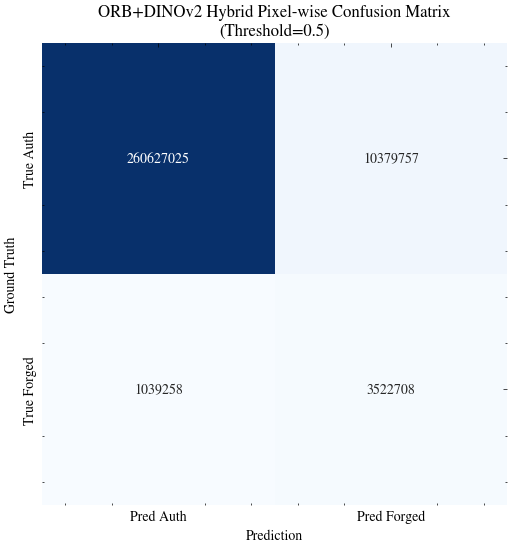

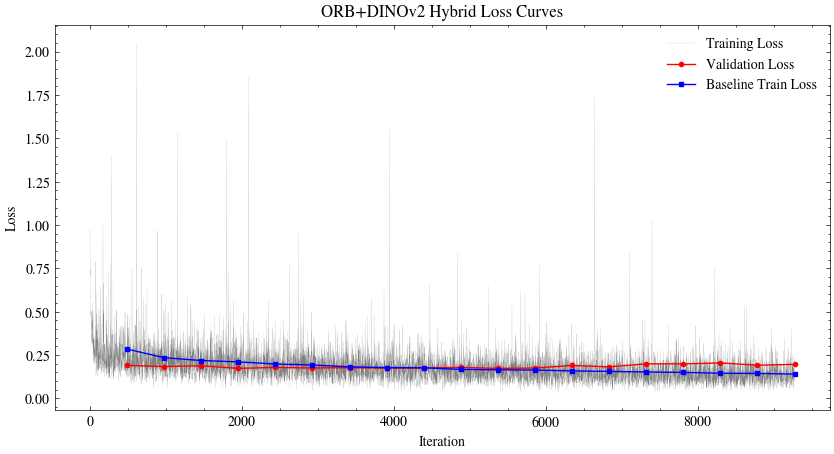

In [12]:
# --- EVALUATION + PLOTTING FOR HYBRID ORB+DINO MODEL ---

import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'no-latex'])

# Load best hybrid model and evaluate
model = DinoSegmenterWithORB().to(CFG.device)
model.load_state_dict(torch.load("DINO_ORB_Hybrid_BEST.pt", map_location=CFG.device))
print("✅ Loaded DINO_ORB_Hybrid_BEST.pt")

# 1. Run Evaluation
thresh = 0.5
oF1, cm, results_df, pixel_metrics = evaluate_hybrid_with_official_metric(
    model, orb_loaders['val_f'], orb_loaders['val_a'], CFG.device, thresh=thresh
)

# 2. Plot Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Auth', 'Pred Forged'],
            yticklabels=['True Auth', 'True Forged'], ax=ax)

ax.set_title(f"ORB+DINOv2 Hybrid Pixel-wise Confusion Matrix\n(Threshold={thresh})")
ax.set_ylabel('Ground Truth')
ax.set_xlabel('Prediction')
ax.tick_params(left=False, bottom=False)
plt.savefig('dino_orb_hybrid_confusion_matrix.pdf', bbox_inches='tight', dpi=300)
plt.show()

# 3. Plot Loss Curves (batch-level training, epoch-level validation)
# Load from CSV if in-memory logs not available
if 'batch_log' not in dir() or len(batch_log) == 0:
    batch_csv = Path("DINO_ORB_Hybrid_batch_losses.csv")
    epoch_csv = Path("DINO_ORB_Hybrid_epoch_metrics.csv")
    if batch_csv.exists() and epoch_csv.exists():
        batch_log = pd.read_csv(batch_csv)["batch_loss"].tolist()
        epoch_log = pd.read_csv(epoch_csv).to_dict('records')

# Baseline training loss values (for comparison)
baseline_train_loss = [
    0.2841, 0.2341, 0.2179, 0.2099, 0.1978, 0.1919, 0.1814, 0.1772, 0.1758, 0.1667,
    0.1642, 0.1628, 0.1582, 0.1550, 0.1519, 0.1492, 0.1445, 0.1433, 0.1397
]

if 'batch_log' in dir() and len(batch_log) > 0 and 'epoch_log' in dir() and len(epoch_log) > 0:
    # Create iteration-indexed dataframe for batch losses
    df = pd.DataFrame({"iteration": range(1, len(batch_log) + 1), "loss": batch_log})
    
    # Calculate validation loss positions (at end of each epoch)
    batches_per_epoch = len(batch_log) // len(epoch_log)
    val_iters = [(i + 1) * batches_per_epoch for i in range(len(epoch_log))]
    val_vals = [e["val_loss"] for e in epoch_log]
    
    # Calculate baseline positions (at end of each epoch, for epochs 1-19)
    baseline_iters = [(i + 1) * batches_per_epoch for i in range(len(baseline_train_loss))]
    
    plt.figure(figsize=(10, 5))
    plt.plot(df["iteration"], df["loss"], label="Training Loss", color="gray", linewidth=0.1)
    plt.plot(val_iters, val_vals, label="Validation Loss", color="red", linewidth=1, marker='o', markersize=3, zorder=5)
    plt.plot(baseline_iters, baseline_train_loss, label="Baseline Train Loss", color="blue", linewidth=1, marker='s', markersize=3, zorder=5)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("ORB+DINOv2 Hybrid Loss Curves")
    plt.legend()
    plt.savefig('dino_orb_hybrid_losscurve.pdf', bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("Training logs not found. Please ensure CSVs exist or 'batch_log'/'epoch_log' are populated.")

In [15]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class LeanDataset(Dataset):
    def __init__(self, patch_meta, split_type='train', transform=None):
        self.patch_meta = patch_meta 
        self.split_type = split_type 
        self.transform = transform
        # Initialize ORB detector once
        self.orb = cv2.ORB_create(nfeatures=3000) 

    def compute_orb_map(self, img_bgr, size):
        """Generates a dense ORB keypoint density map."""
        try:
            gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            kp = self.orb.detect(gray, None)
            
            # Create an empty map
            orb_map = np.zeros((img_bgr.shape[0], img_bgr.shape[1]), dtype=np.float32)
            
            # Fill keypoints
            for k in kp:
                x, y = int(k.pt[0]), int(k.pt[1])
                if 0 <= y < orb_map.shape[0] and 0 <= x < orb_map.shape[1]:
                    orb_map[y, x] = 1.0
            
            # Resize to match patch size if necessary (though usually it matches)
            if orb_map.shape[:2] != (size, size):
                orb_map = cv2.resize(orb_map, (size, size), interpolation=cv2.INTER_NEAREST)
                
            # Slight blur to create a "density" field rather than sparse pixels
            orb_map = cv2.GaussianBlur(orb_map, (5, 5), 0)
            
            # Normalize
            if orb_map.max() > 0:
                orb_map /= orb_map.max()
                
            return orb_map
        except:
            return np.zeros((size, size), dtype=np.float32)

    def __len__(self): return len(self.patch_meta)
    
    def __getitem__(self, idx):
        img_path, x, y, size, is_forged = self.patch_meta[idx]
        try:
            # 1. Load Image
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None: raise ValueError("Image not found")
            
            # 2. Load Mask
            mask = None
            if is_forged:
                m_path = Path(img_path).parents[1] / "masks" / (Path(img_path).stem + ".npy")
                if m_path.exists():
                    mask = np.load(m_path)
                    if mask.ndim == 3: mask = mask[0]
            
            # 3. Crop/Slice Logic (Patch-based)
            if self.split_type == 'val': # Logic for full images (if used)
                 # ... (Your previous resize logic if needed, but we are using patches now)
                 pass 
            
            # SLICING (Used for 'train' and 'train_patches')
            h, w, _ = img.shape
            y_end, x_end = min(y + size, h), min(x + size, w)
            
            patch_img = img[y:y_end, x:x_end]
            
            # Handle Mask
            if mask is None:
                patch_mask = np.zeros((patch_img.shape[0], patch_img.shape[1]), dtype=np.float32)
            else:
                patch_mask = mask[y:y_end, x:x_end].astype(np.float32)

            # Padding if patch is too small (edges)
            if patch_img.shape[:2] != (size, size):
                pad_h = size - patch_img.shape[0]
                pad_w = size - patch_img.shape[1]
                patch_img = cv2.copyMakeBorder(patch_img, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT)
                patch_mask = cv2.copyMakeBorder(patch_mask, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT)

            # 4. Generate ORB Map (Computed on the crop!)
            orb_map = self.compute_orb_map(patch_img, size)

            # 5. Augmentations / Conversions
            patch_img_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                # Albumentations expects 'image' and 'mask'. We handle ORB separately or as an extra mask if needed.
                # Usually we don't augment ORB map geometrically without care, but for Val it's just Normalize.
                augmented = self.transform(image=patch_img_rgb, mask=patch_mask)
                tens_img = augmented['image']
                tens_mask = augmented['mask'].unsqueeze(0)
            else:
                tens_img = torch.from_numpy(patch_img_rgb).permute(2,0,1).float() / 255.0
                tens_mask = torch.from_numpy(patch_mask).unsqueeze(0)
            
            tens_orb = torch.from_numpy(orb_map).unsqueeze(0).float()
            
            # RETURN 3 ITEMS: Image, ORB, Mask
            return tens_img, tens_orb, tens_mask

        except Exception as e: 
            # Fallback for errors
            z = torch.zeros((3, size, size))
            m = torch.zeros((1, size, size))
            o = torch.zeros((1, size, size))
            return z, o, m

In [16]:
# Re-create loaders with the updated LeanDataset class
orb_loaders = {
    'val_f': DataLoader(
        LeanDataset(all_val_f, split_type='train_patches', transform=val_trans), 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=0 # Keep at 0 for Windows
    ),
    'val_a': DataLoader(
        LeanDataset(all_val_a, split_type='train_patches', transform=val_trans), 
        batch_size=CFG.batch_size, 
        shuffle=False, 
        num_workers=0 # Keep at 0 for Windows
    )
}

print("✅ LeanDataset updated with ORB support.")
print(f"✅ Loaders refreshed. Ready for evaluation.")

# --- NOW RUN YOUR EVALUATION CODE ---
thresh = 0.5
print("\n🚀 Starting Evaluation...")
oF1, cm, results_df, pixel_metrics = evaluate_hybrid_with_official_metric(
    model, orb_loaders['val_f'], orb_loaders['val_a'], CFG.device, thresh=thresh
)

✅ LeanDataset updated with ORB support.
✅ Loaders refreshed. Ready for evaluation.

🚀 Starting Evaluation...


Evaluating forged:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating authentic:   0%|          | 0/59 [00:00<?, ?it/s]


🏆 EVALUATION RESULTS:
   Official Competition Metric (oF1): 0.4229
   Pixel-wise F1:                     0.6298
   Pixel Precision:                   0.4901
   Pixel Recall:                      0.8810


✅ Confusion Matrix saved to 'dino_orb_hybrid_confusion_matrix.pdf'


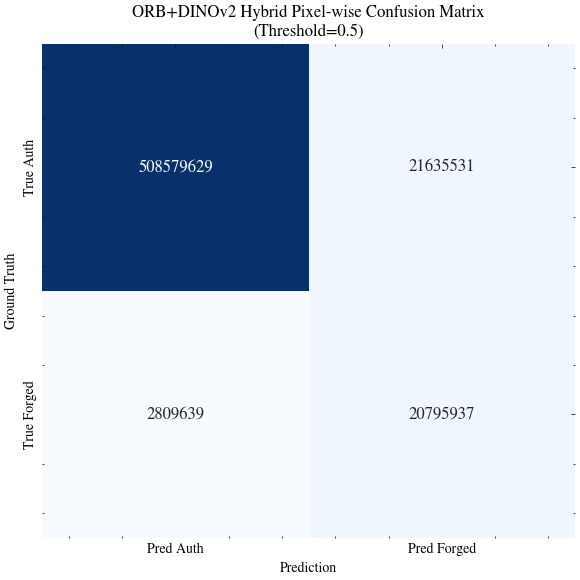

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

# Optional: Use science plots style if available, otherwise default
try:
    plt.style.use(['science', 'no-latex'])
except:
    plt.style.use('default')

# --- PLOT CONFUSION MATRIX ---
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Heatmap with exact same parameters
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Auth', 'Pred Forged'],
            yticklabels=['True Auth', 'True Forged'], 
            annot_kws={"size": 12}, 
            ax=ax)

# Titles and Labels matching your reference
ax.set_title(f"ORB+DINOv2 Hybrid Pixel-wise Confusion Matrix\n(Threshold={thresh})")
ax.set_ylabel('Ground Truth')
ax.set_xlabel('Prediction')

# Remove ticks for cleaner look
ax.tick_params(left=False, bottom=False)

plt.tight_layout()
plt.savefig('dino_orb_hybrid_confusion_matrix.pdf', bbox_inches='tight', dpi=300)
print("✅ Confusion Matrix saved to 'dino_orb_hybrid_confusion_matrix.pdf'")
plt.show()

🔍 Forged Image Predictions:


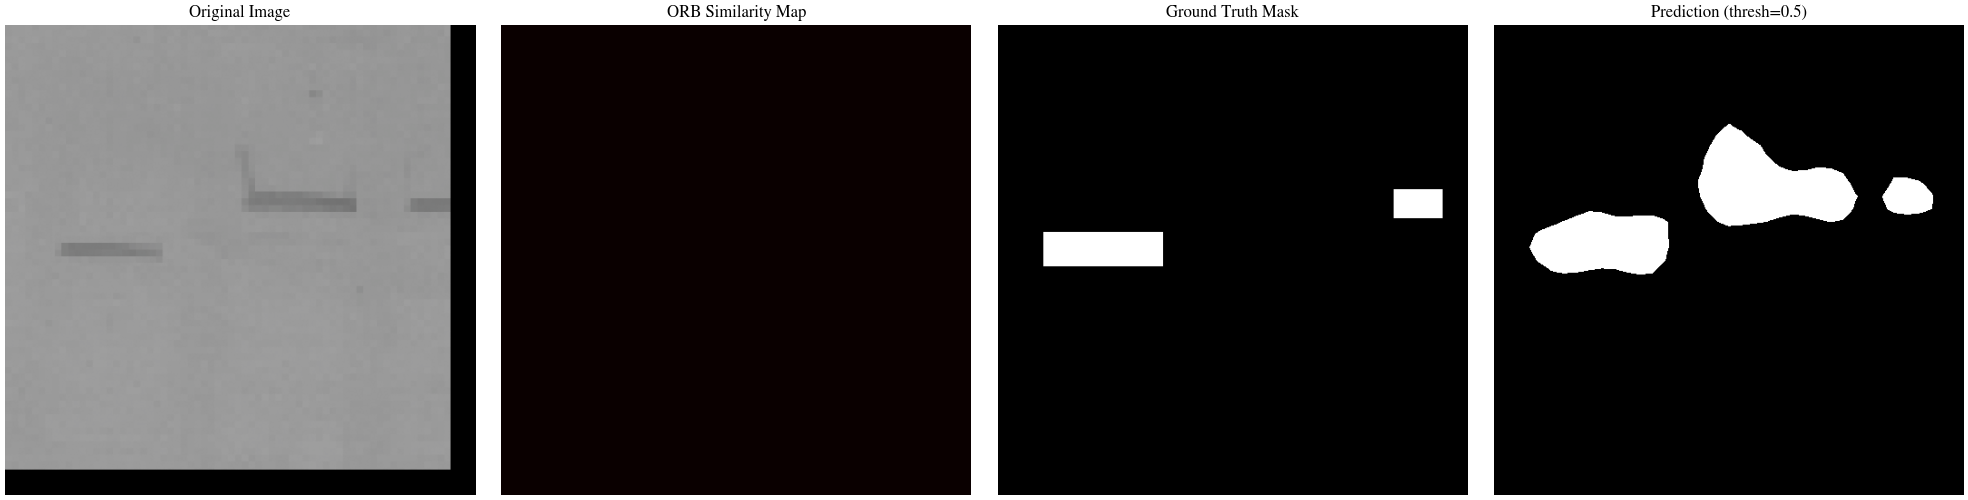

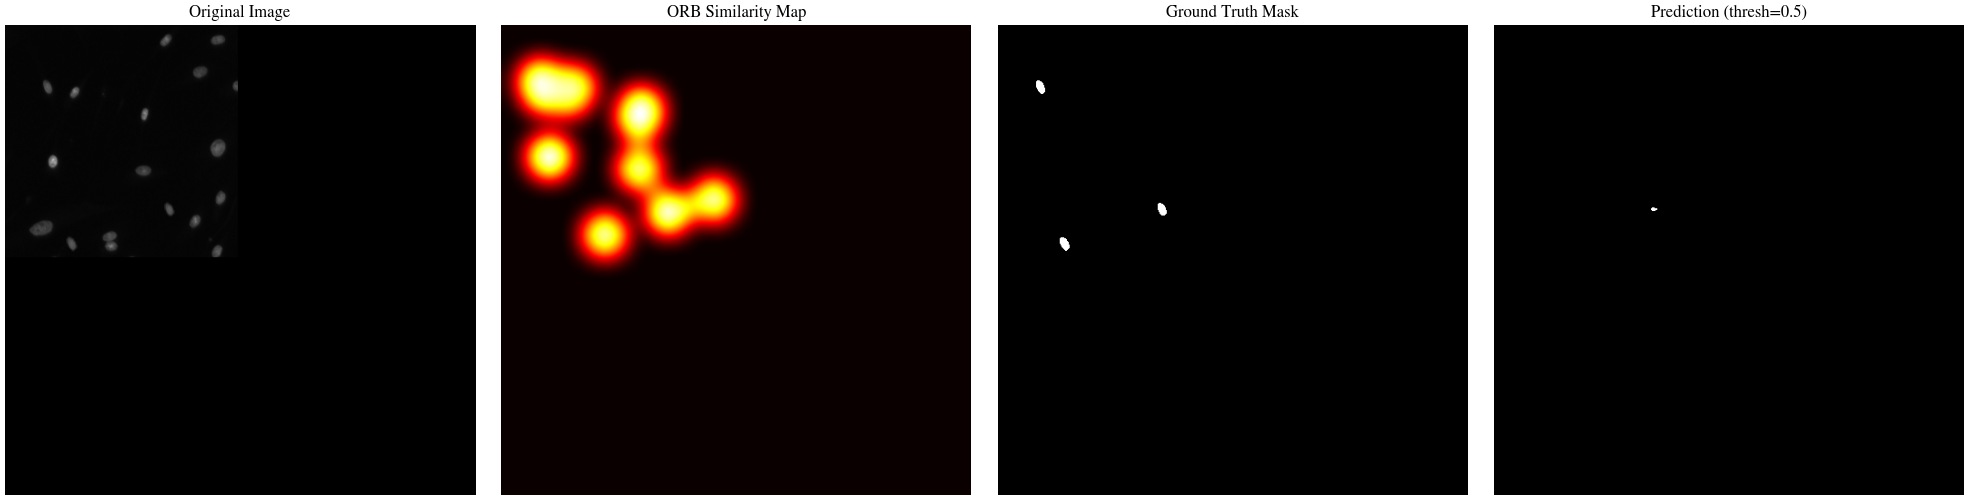

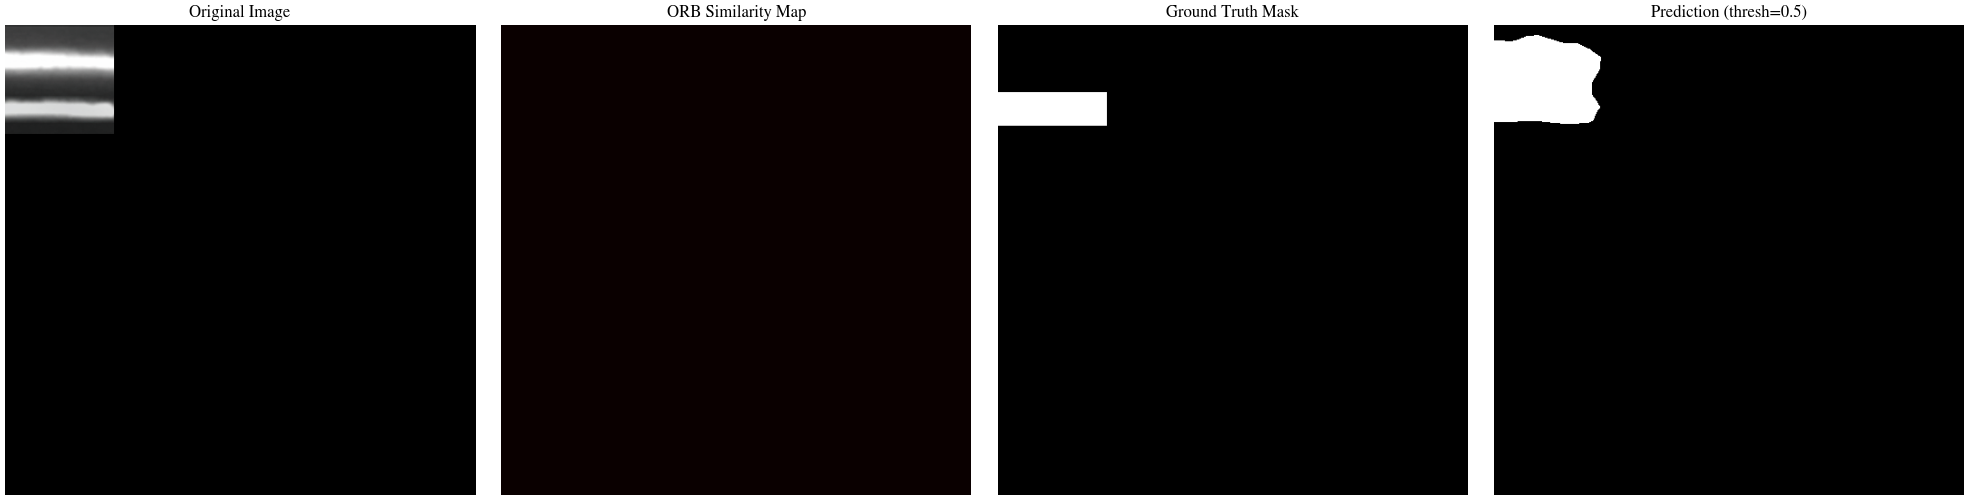


🔍 Authentic Image Predictions:


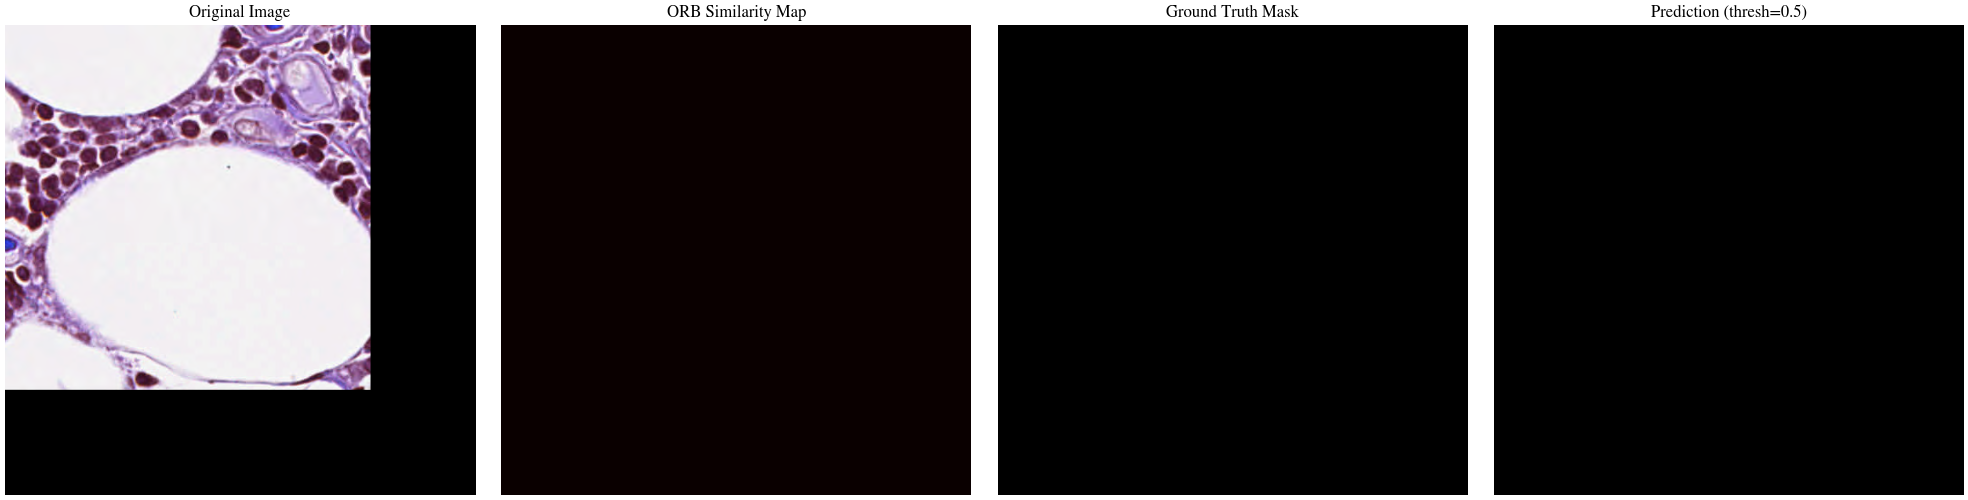

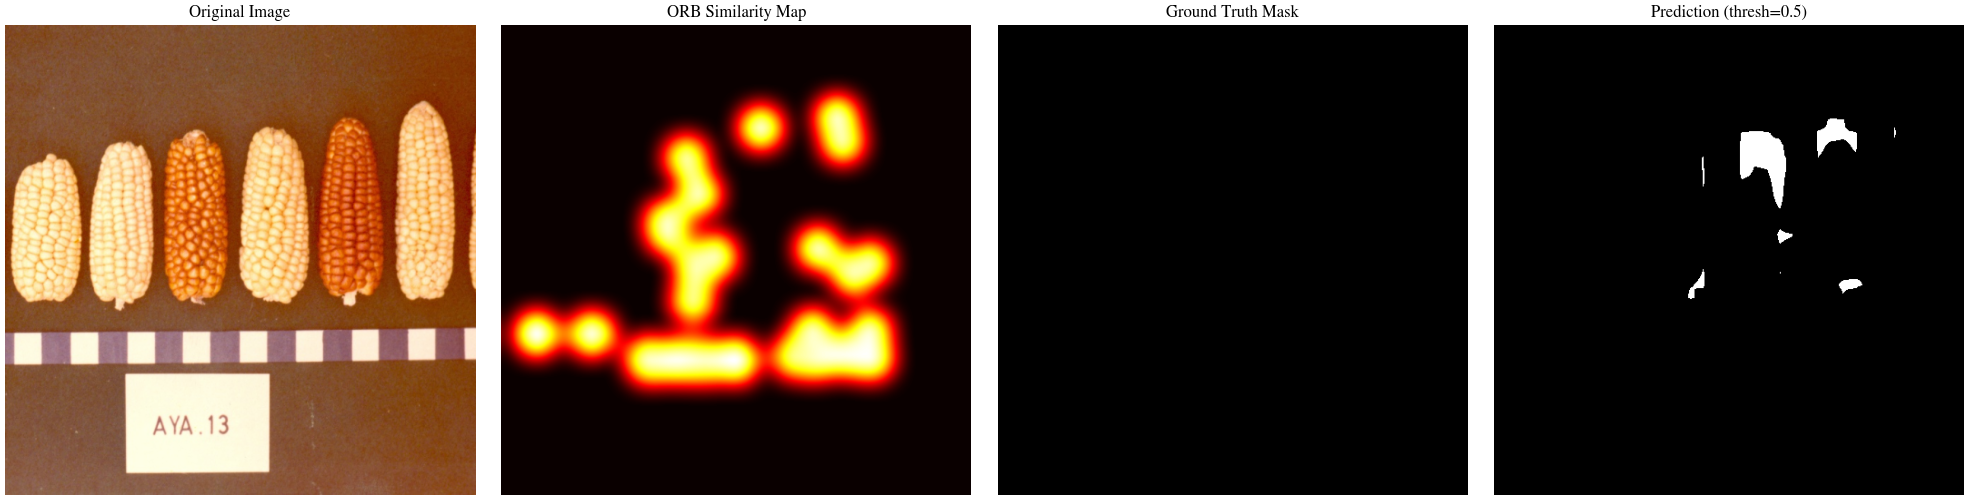

In [10]:
# --- VISUALIZE SAMPLE PREDICTIONS ---

def visualize_hybrid_predictions(model, loader, device, num_samples=5, thresh=0.5):
    """Visualize original image, ground truth mask, and model prediction."""
    model.eval()
    
    # Denormalization constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    samples_shown = 0
    
    with torch.no_grad():
        for images, orb_maps, masks in loader:
            images = images.to(device)
            orb_maps = orb_maps.to(device)
            
            with torch.amp.autocast('cuda'):
                logits = model(images, orb_maps)
                probs = torch.sigmoid(logits)
                preds = (probs > thresh).float()
            
            for b in range(images.size(0)):
                if samples_shown >= num_samples:
                    return
                
                # Denormalize image for display
                img_np = images[b].cpu().numpy().transpose(1, 2, 0)
                img_np = (img_np * std + mean).clip(0, 1)
                
                mask_np = masks[b, 0].cpu().numpy()
                pred_np = preds[b, 0].cpu().numpy()
                orb_np = orb_maps[b, 0].cpu().numpy()
                
                plt.figure(figsize=(20, 5))
                
                plt.subplot(1, 4, 1)
                plt.title("Original Image")
                plt.imshow(img_np)
                plt.axis('off')
                
                plt.subplot(1, 4, 2)
                plt.title("ORB Similarity Map")
                plt.imshow(orb_np, cmap='hot')
                plt.axis('off')
                
                plt.subplot(1, 4, 3)
                plt.title("Ground Truth Mask")
                plt.imshow(mask_np, cmap='gray')
                plt.axis('off')
                
                plt.subplot(1, 4, 4)
                plt.title(f"Prediction (thresh={thresh})")
                plt.imshow(pred_np, cmap='gray')
                plt.axis('off')
                
                plt.tight_layout()
                plt.savefig(f'hybrid_prediction_sample_{samples_shown}.pdf', bbox_inches='tight', dpi=300)
                plt.show()
                
                samples_shown += 1

# Visualize forged samples
print("🔍 Forged Image Predictions:")
visualize_hybrid_predictions(model, orb_loaders['val_f'], CFG.device, num_samples=3, thresh=0.5)

# Visualize authentic samples  
print("\n🔍 Authentic Image Predictions:")
visualize_hybrid_predictions(model, orb_loaders['val_a'], CFG.device, num_samples=2, thresh=0.5)